# Algoritmo de quasi_newton_DFP

### Función de prueba

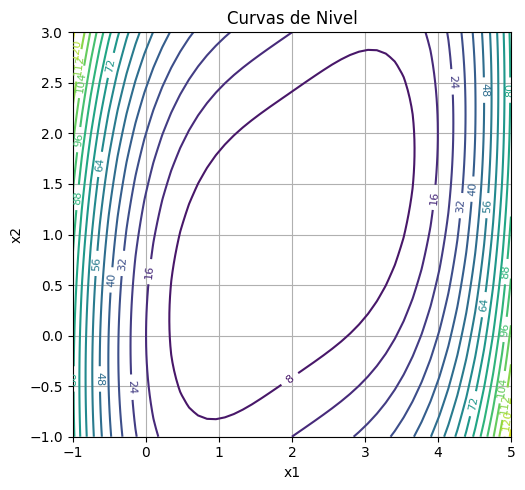

La función f(x1, x2) = (x1 - 2)⁴ + (x1 - 2x2)² tiene:
- Derivada parcial respecto a x1: ∂f/∂x1 = 4(x1-2)³ + 2(x1-2x2)
- Derivada parcial respecto a x2: ∂f/∂x2 = -4(x1-2x2)
- Punto crítico teórico: (x1, x2) = (2, 1)


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def quasiconvex_function(x):
  """
  Función de dos variables: f(x1, x2) = (x1 - 2)^4 + (x1 - 2*x2)^2
  Para graficar, usaremos x1 = x y x2 = 0 como caso particular
  """
  if isinstance(x, (list, tuple, np.ndarray)) and len(x) == 2:
    x1, x2 = x
    return (x1 - 2)**4 + (x1 - 2*x2)**2
  else:
    # Para compatibilidad con el código existente, asumimos x2 = 0
    x1 = x
    x2 = 0
    return (x1 - 2)**4 + (x1 - 2*x2)**2

# Crear gráfica 3D de la función de dos variables
fig = plt.figure(figsize=(15, 5))

# Definir las variables necesarias para el meshgrid
x1_range = np.linspace(-1, 5, 50)
x2_range = np.linspace(-1, 3, 50)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = (X1 - 2)**4 + (X1 - 2*X2)**2

""" # Subplot 1: Gráfica 3D
ax1 = fig.add_subplot(131, projection='3d')

surface = ax1.plot_surface(X1, X2, Z, cmap='viridis', alpha=0.8)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('f(x1, x2)')
ax1.set_title('Función 3D: (x1-2)⁴ + (x1-2x2)²') """

# Subplot 2: Curvas de nivel
ax2 = fig.add_subplot(132)
contour = ax2.contour(X1, X2, Z, levels=20)
ax2.clabel(contour, inline=True, fontsize=8)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Curvas de Nivel')
ax2.grid(True)

""" # Subplot 3: Corte con x2 = 0 para compatibilidad
ax3 = fig.add_subplot(133)
x_values = np.linspace(-1, 5, 100)
y_values = [quasiconvex_function(x) for x in x_values] 

ax3.plot(x_values, y_values, label='f(x1, 0) = (x1-2)⁴ + x1²', linewidth=2, color='red')
ax3.set_xlabel('x1')
ax3.set_ylabel('f(x1, 0)')
ax3.set_title('Corte en x2 = 0')
ax3.grid(True)
ax3.legend() """

plt.tight_layout()
plt.show()

print(f"La función f(x1, x2) = (x1 - 2)⁴ + (x1 - 2x2)² tiene:")
print(f"- Derivada parcial respecto a x1: ∂f/∂x1 = 4(x1-2)³ + 2(x1-2x2)")
print(f"- Derivada parcial respecto a x2: ∂f/∂x2 = -4(x1-2x2)")
print(f"- Punto crítico teórico: (x1, x2) = (2, 1)")

### Desarrollo del algoritmo

In [13]:
def gradient(x, h=1e-8):
    """Calcula el gradiente usando diferencias finitas centrales"""
    x1, x2 = x
    
    # Diferencia finita para x1
    df_dx1 = (quasiconvex_function([x1 + h, x2]) - quasiconvex_function([x1 - h, x2])) / (2 * h)
    
    # Diferencia finita para x2
    df_dx2 = (quasiconvex_function([x1, x2 + h]) - quasiconvex_function([x1, x2 - h])) / (2 * h)
    
    return np.array([df_dx1, df_dx2])

def hessian(x, h=1e-5):
    """Calcula la matriz Hessiana usando diferencias finitas"""
    x1, x2 = x
    
    # Segundas derivadas parciales
    # d2f/dx1^2
    d2f_dx1_dx1 = (quasiconvex_function([x1 + h, x2]) - 2*quasiconvex_function([x1, x2]) + quasiconvex_function([x1 - h, x2])) / (h**2)
    
    # d2f/dx2^2
    d2f_dx2_dx2 = (quasiconvex_function([x1, x2 + h]) - 2*quasiconvex_function([x1, x2]) + quasiconvex_function([x1, x2 - h])) / (h**2)
    
    # d2f/dx1dx2 (derivada mixta)
    d2f_dx1_dx2 = (quasiconvex_function([x1 + h, x2 + h]) - quasiconvex_function([x1 + h, x2 - h]) - 
                    quasiconvex_function([x1 - h, x2 + h]) + quasiconvex_function([x1 - h, x2 - h])) / (4 * h**2)
    
    return np.array([[d2f_dx1_dx1, d2f_dx1_dx2],
                    [d2f_dx1_dx2, d2f_dx2_dx2]])

def is_positive_definite(matrix):
    """Verifica si una matriz es definida positiva usando Cholesky"""
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False
    

In [14]:
def davidon_fletcher_powell(initial_point, tolerance=1e-6, max_iterations=100, alpha=1.0, beta=0.5, c1=1e-4):
    """
    Implementación del método Davidon-Fletcher-Powell (DFP)
    
    Parameters:
    -----------
    initial_point : array-like
        Punto inicial [x1, x2]
    tolerance : float
        Tolerancia de convergencia
    max_iterations : int
        Máximo número de iteraciones
    alpha : float
        Tamaño de paso inicial para búsqueda lineal
    beta : float
        Factor de reducción para búsqueda lineal
    c1 : float
        Parámetro para condición de Armijo
    
    Returns:
    --------
    result : dict
        Diccionario con resultados del algoritmo
    """
    
    # Paso 1: Inicialización
    y = np.array(initial_point, dtype=float)
    n = len(y)
    D = np.eye(n)  # Matriz inicial (identidad)
    j = 0
    
    # Almacenar historial
    history = {
        'points': [y.copy()],
        'function_values': [quasiconvex_function(y)],
        'gradients': [],
        'iterations': []
    }
    
    # Evaluar gradiente inicial
    g = gradient(y)
    history['gradients'].append(np.linalg.norm(g))
    
    print(f"Iteración {j}: y = {y}, f(y) = {quasiconvex_function(y):.6f}, ||∇f|| = {np.linalg.norm(g):.6f}")
    
    # Paso 2: Bucle principal
    while np.linalg.norm(g) > tolerance and j < max_iterations:
        
        # Paso 2.1: Calcular dirección de búsqueda
        d = -D @ g
        
        # Paso 2.2: Búsqueda lineal (método de Armijo)
        lambda_j = alpha
        while quasiconvex_function(y + lambda_j * d) > quasiconvex_function(y) + c1 * lambda_j * (g.T @ d):
            lambda_j *= beta
            if lambda_j < 1e-12:  # Evitar pasos muy pequeños
                break
        
        # Paso 2.3: Actualizar el punto
        y_new = y + lambda_j * d
        
        # Paso 2.4: Calcular gradiente nuevo
        g_new = gradient(y_new)
        
        # Paso 2.5: Definir incrementos
        p = y_new - y
        q = g_new - g
        
        # Paso 2.6: Actualizar matriz DFP (solo si q^T p > 0 para mantener definida positiva)
        if np.dot(q, p) > 1e-12:
            # Término 1: p * p^T / (p^T * q)
            term1 = np.outer(p, p) / np.dot(p, q)
            
            # Término 2: (D * q * q^T * D) / (q^T * D * q)
            Dq = D @ q
            term2 = np.outer(Dq, Dq) / (q.T @ Dq)
            
            # Actualización DFP
            D = D + term1 - term2
        
        # Paso 2.7: Preparar siguiente iteración
        y = y_new
        g = g_new
        j += 1
        
        # Guardar historial
        history['points'].append(y.copy())
        history['function_values'].append(quasiconvex_function(y))
        history['gradients'].append(np.linalg.norm(g))
        history['iterations'].append(j)
        
        print(f"Iteración {j}: y = {y}, f(y) = {quasiconvex_function(y):.6f}, ||∇f|| = {np.linalg.norm(g):.6f}")
    
    # Resultado final
    result = {
        'optimal_point': y,
        'optimal_value': quasiconvex_function(y),
        'iterations': j,
        'gradient_norm': np.linalg.norm(g),
        'converged': np.linalg.norm(g) <= tolerance,
        'history': history
    }
    
    return result

Iteración 0: y = [0. 3.], f(y) = 52.000000, ||∇f|| = 50.119856
Iteración 1: y = [2.75000001 1.50000001], f(y) = 0.378906, ||∇f|| = 1.552468
Iteración 2: y = [2.5802036  1.18559702], f(y) = 0.157009, ||∇f|| = 1.461935
Iteración 3: y = [2.5059285  1.21737319], f(y) = 0.070584, ||∇f|| = 0.719130
Iteración 4: y = [2.38571605 1.20523874], f(y) = 0.022748, ||∇f|| = 0.205468
Iteración 5: y = [2.30959094 1.16947916], f(y) = 0.010049, ||∇f|| = 0.131887
Iteración 6: y = [2.22913745 1.12093391], f(y) = 0.002919, ||∇f|| = 0.055736
Iteración 7: y = [2.17406004 1.08725859], f(y) = 0.000918, ||∇f|| = 0.020262
Iteración 8: y = [2.13400479 1.06538991], f(y) = 0.000333, ||∇f|| = 0.020611
Iteración 9: y = [2.10208679 1.04971948], f(y) = 0.000116, ||∇f|| = 0.014262
Iteración 10: y = [2.07659394 1.03783862], f(y) = 0.000035, ||∇f|| = 0.005160
Iteración 11: y = [2.05814804 1.02914268], f(y) = 0.000011, ||∇f|| = 0.000751
Iteración 12: y = [2.04463661 1.02251924], f(y) = 0.000004, ||∇f|| = 0.001669
Iteración 

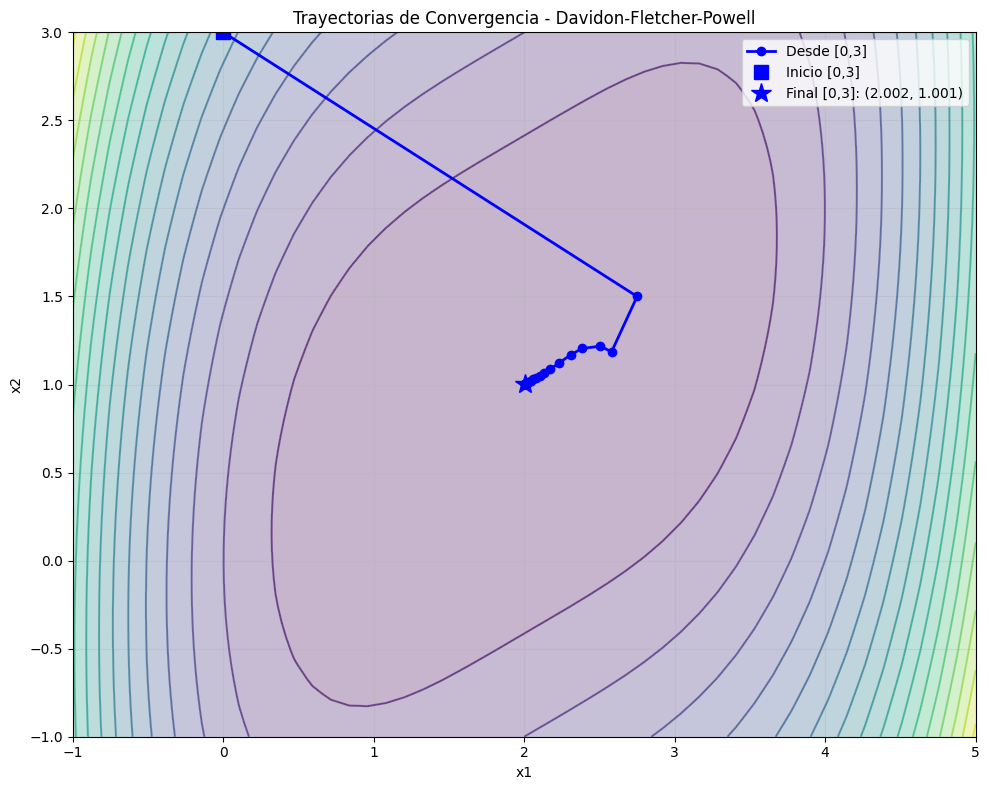


=== RESUMEN DE RESULTADOS ===
Punto Inicial   Solución Final       f(x) Final      Iteraciones 
----------------------------------------------------------------------
[0, 3]          [2.002, 1.001]    2.123766e-11    23          


In [15]:
# Ejecutar con punto inicial [0, 3]
result_dfp = davidon_fletcher_powell([0, 3])

# Visualizar solo las trayectorias de convergencia
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Gráfico: Trayectorias sobre las curvas de nivel
ax.contour(X1, X2, Z, levels=20, alpha=0.6)
ax.contourf(X1, X2, Z, levels=20, alpha=0.3, cmap='viridis')

# Trayectoria desde [0, 3]
points = result_dfp['history']['points']
x_traj = [point[0] for point in points]
y_traj = [point[1] for point in points]
ax.plot(x_traj, y_traj, 'bo-', linewidth=2, markersize=6, label='Desde [0,3]')
ax.plot(x_traj[0], y_traj[0], 'bs', markersize=10, label='Inicio [0,3]')
ax.plot(x_traj[-1], y_traj[-1], 'b*', markersize=15, 
    label=f'Final [0,3]: ({result_dfp["optimal_point"][0]:.3f}, {result_dfp["optimal_point"][1]:.3f})')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Trayectorias de Convergencia - Davidon-Fletcher-Powell')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabla comparativa de resultados
print("\n=== RESUMEN DE RESULTADOS ===")
print(f"{'Punto Inicial':<15} {'Solución Final':<20} {'f(x) Final':<15} {'Iteraciones':<12}")
print("-" * 70)
print(f"[0, 3]          [{result_dfp['optimal_point'][0]:.3f}, {result_dfp['optimal_point'][1]:.3f}]    {result_dfp['optimal_value']:<15.6e} {result_dfp['iterations']:<12}")
